In [1]:
from skimage.color import label2rgb, rgb2gray
from skimage.segmentation import mark_boundaries
import keras
from keras import layers
from keras.layers import Dense
import numpy as np
import tensorflow as tf
import cv2
from cv2 import imread, createCLAHE
import glob
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from IPython.display import clear_output
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from skimage.morphology import binary_erosion, disk
import keras.backend as K
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
import numpy as np
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.segmentation import mark_boundaries
from scipy.ndimage import binary_erosion
from skimage.morphology import disk

2023-06-09 12:56:04.319690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 12:56:04.530471: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-09 12:56:04.543243: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-09 12:56:04.543257: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [10]:
# Specify the paths to the folders containing the NPZ files
images_folder_path = '/home/somayeh/PycharmProjects/superpixel_segmentation/liver/2-1'
ground_truth_folder_path = '/home/somayeh/PycharmProjects/superpixel_segmentation/liver/2-0/liver'

In [11]:
# Get a list of all NPZ files in the images folder
images_npz_files = glob.glob(images_folder_path + '/*.npz')

In [12]:
from skimage.util import img_as_ubyte
from scipy.ndimage import sobel
def ground_truth_superpixel_1(img, ground_truth):


    # Perform superpixel segmentation
    num_segments = 500
    segments = slic(img, n_segments=num_segments, compactness=10)
    # segments = felzenszwalb(img, scale=20, sigma=0.5, min_size=30)
    # segments = quickshift(img, kernel_size=1, max_dist=2.5, ratio=0.5)

    # Create a mask image based on the segment labels
    # Create a superpixel boundary overlay on the original image
    # overlay = mark_boundaries(img, segments)
    #
    # # Convert the overlay image to PIL Image
    # overlay_image = Image.fromarray(img_as_ubyte(overlay))


    # gradient = sobel(rgb2gray(img))
    # segments = watershed(gradient, markers=800, compactness=0.001)

    image_superpixel = label2rgb(segments, img, kind='avg')
    image_superpixel = image_superpixel[:, :, 0]  # Convert to 2D grayscale image
    #
    # image_superpixel = rgb2gray(image_superpixel)
    num_superpixels = len(np.unique(segments))
    print(f'The image contains {num_superpixels} superpixels.')

    image_boundaries = mark_boundaries(img, segments, color=(255, 0, 0))
    labels = segments.astype(np.int32)

    # Overlay superpixels with ground truth
    inside_mask = (ground_truth == 255)  # white pixels in ground truth are inside the chest region
    outside_mask = (ground_truth == 0)  # black pixels in ground truth are outside the chest region
    boundary_mask = cv2.morphologyEx(ground_truth, cv2.MORPH_GRADIENT, np.ones((5, 5), np.uint8)) > 0

    inside_superpixels = set(np.unique(labels[inside_mask]))
    outside_superpixels = set(np.unique(labels[outside_mask]))
    boundary_superpixels = set(np.unique(labels[boundary_mask]))

    # Exclude boundary superpixels
    valid_superpixels = list(outside_superpixels.union(inside_superpixels) - boundary_superpixels)

    for label in boundary_superpixels:
        mask = (labels == label)
        # Check if the superpixel intersects with the boundary
        if np.any(mask[0, :]) or np.any(mask[-1, :]) or np.any(mask[:, 0]) or np.any(mask[:, -1]):
            boundary_mask_ = binary_erosion(boundary_mask,
                                            disk(
                                                3))  # erode the boundary mask to avoid including partial boundary pixels
            valid_superpixels = list(outside_superpixels.union(inside_superpixels) - set(labels[boundary_mask_]))

    num_segments_result = len(np.unique(valid_superpixels))
    print(f'The result image contains {num_segments_result} superpixels.')

    # Assign labels and color superpixels
    # result = np.zeros_like(img)
    result = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # result = np.zeros_like(img)
    inside_labels = []
    outside_labels = []
    for label in valid_superpixels:
        mask = (labels == label)
        if label in inside_superpixels:
            color = np.array([255, 255, 0])  # yellow for inside superpixels
            inside_labels.append(label)
        else:
            color = np.array([0, 0, 255])  # blue for outside superpixels
            outside_labels.append(label)
        result[mask] = color

        for i in range(result.shape[2]):  # iterate over each channel of result
             result[:,:,i][mask] = color[i]

    # Set background class for the omitted superpixels
    # background_mask = (ground_truth == 0)
    # result[background_mask] = (0, 0, 0)
    plt.imshow(image_boundaries)
    plt.axis('off')
    plt.show()

    return result

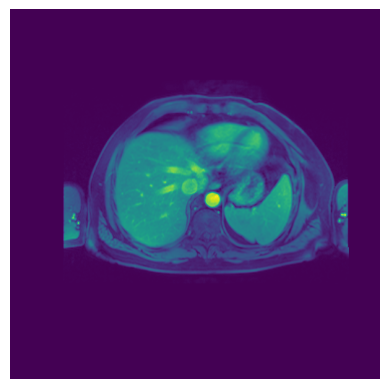

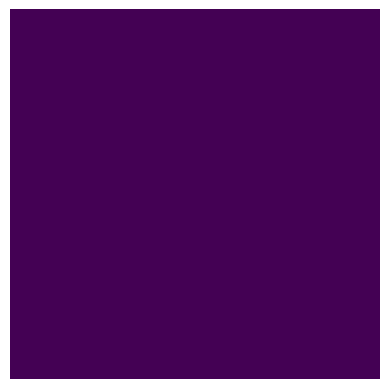

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


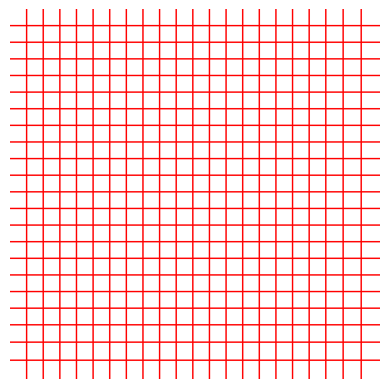

In [41]:
import os
# Iterate over each NPZ file in the images folder
import random
from PIL import Image
for image_file in images_npz_files:
    # Extract the file name without the extension
    file_name = image_file.split('/')[-1].split('.')[0]

    # Construct the corresponding path for the ground truth file
    ground_truth_file = ground_truth_folder_path + '/' + file_name + '.npz'

    # Shuffle the images_npz_files list randomly
    random.shuffle(images_npz_files)

    # Select a random image file from the shuffled list
    random_image_file = random.choice(images_npz_files)

    # Load the randomly selected image file
    image_data = np.load(random_image_file)

    # Load the image NPZ file
    # image_data = np.load(image_file)

    # Load the ground truth NPZ file
    ground_truth_data = np.load(ground_truth_file)

    # Access the image array within the image NPZ file
    image_array = image_data['arr_0']
    # print(image_array)
    # print(image_array.ndim)
    # print(image_array.shape)

    # Access the ground truth array within the ground truth NPZ file
    ground_truth_array = ground_truth_data['arr_0']
    # print(ground_truth_array)
    # print(ground_truth_array.ndim)
    # print(ground_truth_array.shape)
    # print("khjh")

    # image_resized = Image.fromarray(image_array).resize((256, 256))
    # gt_resized = Image.fromarray(ground_truth_array).resize((256, 256))
    # image_add_chanel = np.expand_dims(image_resized, axis=-1)
    # gt_add_chanel = np.expand_dims(gt_resized, axis=-1)
    # image_resized = image_resized.convert('L')
    # gt_resized = gt_resized.convert('L')
    num_segments = 500
    segments = slic(image_array, n_segments=num_segments, compactness=20)
    # segments = felzenszwalb(image_resized, scale=20, sigma=0.5, min_size=30)
    # segments = quickshift(image_resized, kernel_size=1, max_dist=2.5, ratio=0.5)
    image_boundaries = mark_boundaries(np.array(image_array), segments, color=(255, 0, 0))

    # result = ground_truth_superpixel_1(np.array(image_resized), np.array(gt_resized))
    # result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    # result = result.convert('L')


    # result_type = result.dtype
    # result_size = result.shape
    # num_channels = result.shape[-1] if len(result_size) == 3 else 1
    #
    # print("Image Type:", result_type)
    # print("Image Size:", result_size)
    # print("Number of Channels:", num_channels)


    plt.imshow(image_array)
    plt.axis('off')
    plt.show()
    # #
    plt.imshow(ground_truth_array)
    plt.axis('off')
    plt.show()

    # plt.imshow(result)
    # plt.axis('off')
    # plt.show()

    plt.imshow(image_boundaries)
    plt.axis('off')
    plt.show()


    # # Normalize the resized image array
    # image_normalized = np.array(image_resized, dtype=np.float32) / 255.0
    # gt_normalized = np.array(result, dtype=np.float32) / 255.

    # result = ground_truth_superpixel_1(image_normalized, gt_normalized)

    # gt_result = cv2.cvtColor(gt_result, cv2.COLOR_BGR2GRAY)

    # # # Print the shape of the image and ground truth arrays
    # image_type = image_normalized.dtype
    # image_size = image_normalized.shape
    # num_channels = image_normalized.shape[-1] if len(image_size) == 3 else 1
    # print("Image Type:", image_type)
    # print("Image Size:", image_size)
    # print("Number of Channels:", num_channels)
    # #
    # gt_type = gt_normalized.dtype
    # gt_size = gt_normalized.shape
    # num_channels_gt = gt_normalized.shape[-1] if len(gt_size) == 3 else 1
    # print("Image Type:", gt_type)
    # print("Image Size:", gt_size)
    # print("Number of Channels:", num_channels_gt)
    # #
    # print('Image shape:', image_size)
    # print('Ground truth shape:', gt_normalized.shape)
    break


In [36]:
# folder_path = '/home/somayeh/my_ml_project_dir/my_ml_project_env/dataset/2-1/'
# folder_path_gt = '/home/somayeh/my_ml_project_dir/my_ml_project_env/dataset/2-0/liver'
#
# # Get a list of all NPZ files in the folder
# npz_files = glob.glob(folder_path + '*.npz')
# npz_files_gt = glob.glob(folder_path_gt + '*.npz')
#
#
# for file, file_gt in zip (npz_files, npz_files_gt):
#
#     # Load the NPZ file
#     data = np.load(file)
#     # Access the NPY array within the NPZ file
#     image_array = data['arr_0']
#     image_type = image_array.dtype
#     image_size = image_array.shape
#     num_channels = image_array.shape[-1] if len(image_size) == 3 else 1
#
#     print("Image Type:", image_type)
#     print("Image Size:", image_size)
#     print("Number of Channels:", num_channels)
#
#     # Visualize the image
#     plt.imshow(image_array, cmap="viridis")
#     plt.axis()
#     plt.show()
#
#     data_gt = np.load(file_gt)
#     # Access the NPY array within the NPZ file
#     image_array_gt = data_gt['arr_0']
#     image_type_gt = image_array_gt.dtype
#     image_size_gt = image_array_gt.shape
#     num_channels_gt = image_array_gt.shape[-1] if len(image_size_gt) == 3 else 1
#
#     print("Image Type:", image_type_gt)
#     print("Image Size:", image_size_gt)
#     print("Number of Channels:", num_channels_gt)
#
#     # Visualize the image
#     plt.imshow(image_array_gt, cmap="viridis")
#     plt.axis()
#     plt.show()
#
#     break

    # Do something with the image_array
    # For example, you can perform operations or analysis on the image data

    # Print the shape of the image array (optional)
    # print('Image shape:', image_array.shape)